In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn_pandas import DataFrameMapper
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.decomposition import PCA
    from sklearn.base import clone
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    import warnings
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


* Al tener el Data Set repartido en 4 archivos diferentes segun la plataforma donde se produjeron las ventas, paso a unificar todo en un mismo DataFrame

In [2]:
import pandas as pd
import os

# Ruta a la carpeta que contiene los archivos
ruta_carpeta = "./csv"
archivos_csv = ["fravega.csv", "ecommerce.csv", "mercadolibre.csv", "megatone.csv"]
dfs = [pd.read_csv(os.path.join(ruta_carpeta, archivo), encoding='latin1', delimiter=';') for archivo in archivos_csv]
sales = pd.concat(dfs, ignore_index=True)

sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA RETIRO OCA,COD. PRODUCTO,CANTIDAD,PRODUCTO,DTO %,FECHA COMPRA,PROVINCIA,LOCALIDAD,PLATAFORMA
8620,NaN,NaN,NaN,1-10-02-002,2.0,ALMOHADAS L.PLACA 80CM,NaN,26/6/2022,BUENOS AIRES,NaN,megatone
6335,1.0,107937002,11/7/2023,1-16-33-018,1.0,CONJUNTO L. DUBÁI TRADICIONAL 180CMX200CM,NaN,26/6/2023,SANTA FE,Santa Fe,mercadolibre
6125,1.0,106921374,19/5/2023,1-14-17-017,1.0,CONJUNTO L. DONATELLO TRADICIONAL 160CMX200CM,NaN,17/5/2023,SANTA CRUZ,Las Heras Guemes,mercadolibre
10522,1,106651857,NaN,NaN,1.0,CONJUNTO L. MILLENIUM TRADICIONAL 140CMX190CM,NaN,11/5/2023,BUENOS AIRES,MATHEU,megatone
2526,1.0,97735238,19/5/2022,1-12-36-002,1.0,NaN,0.0,16/5/2022,NEUQUÉN,Zapala,mercadolibre


## Listado de variables 

#### Variables de entrada

* VALOR PRED.: Representa el valor del bulto.
* ORDEN DE RETIRO: Nro de orden por la cual la empresa identifica cada venta
* FECHA RETIRO OCA: Fecha donde OCA retira el producto
* COD. PRODUCTO: Identificador único de cada producto.
* PRODUCTO: Descripción del producto
* DTO %: Descuento aplicado en cada venta.
* FECHA COMPRA: Fecha en la que se realizó la compra del producto
* PROVINCIA: Nombre de la provincia donde se produjo de la venta
* LOCALIDAD: Nombre de la localidad donde se produjo de la venta
* PLATAFORMA: Canal o medio donde se produjo la venta.

#### Variable de salida: 

* CANTIDAD: representa el número de unidades vendidas por producto

#### Reorganizo las columnas en el orden deseado

In [3]:
orden_columnas = [
    'VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA COMPRA', 'FECHA RETIRO OCA','COD. PRODUCTO', 'PRODUCTO', 'DTO %', 'PROVINCIA', 'LOCALIDAD', 'PLATAFORMA',
    'CANTIDAD'
]

sales = sales[orden_columnas]
sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
3791,1.0,ANDESMAR,1/11/2022,3/11/2022,1-23-36-005,NaN,NaN,MENDOZA,Carrodilla,mercadolibre,1.0
6228,1.0,NaN,11/6/2023,16/6/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,NaN,BUENOS AIRES,Nordelta,mercadolibre,1.0
5944,1.0,NaN,11/5/2023,12/5/2023,1-15-36-003,CONJUNTO L. SANZIO TRADICIONAL 90CMX190CM,NaN,BUENOS AIRES,Virrey del Pino,mercadolibre,1.0
2739,1.0,98299154,3/6/2022,8/6/2022,1-11-15-006,NaN,10.0,CHACO,Barrio Las Malvinas Barranqueras,mercadolibre,1.0
1525,1,93168716,27/10/2021,28/10/2021,NaN,COLCHÓN L. REMBRANDT TRADICIONAL 140CMX190CM,"$ 0,00",CORRIENTES,MONTE CASEROS,ecommerce,1


## Análisis detallado de un conjunto de variables

La variable CANTIDAD representa el número de unidades vendidas. Es la variable objetivo de este análisis, ya que el modelo buscará predecir su valor en función de las características del dataset.

Predecir CANTIDAD permitirá:

* Identificar tendencias de venta.
* Optimizar la planificación de inventarios.
* Mejorar la estrategia de ventas y promociones.

### Estadísticas descriptivas de la variable de salida

In [4]:
print("Estadísticas descriptivas de 'CANTIDAD':")
print(sales['CANTIDAD'].describe())

Estadísticas descriptivas de 'CANTIDAD':
count     11103
unique       15
top           1
freq       8976
Name: CANTIDAD, dtype: int64


In [5]:
# Convierto la columna 'CANTIDAD' a numérico, convirtiendo valores no válidos a NaN
sales['CANTIDAD'] = pd.to_numeric(sales['CANTIDAD'], errors='coerce')
# Reemplazo los valores NaN con 1
sales['CANTIDAD'] = sales['CANTIDAD'].fillna(1)
# Convierto la columna a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)

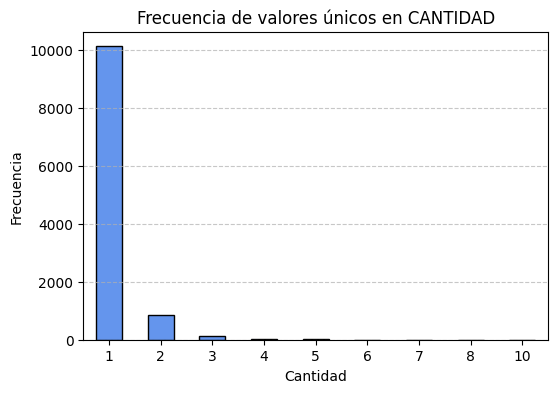

In [6]:
# Frecuencia de valores únicos en 'CANTIDAD'
frecuencia_cantidad = sales['CANTIDAD'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(6, 4))
frecuencia_cantidad.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Frecuencia de valores únicos en CANTIDAD', fontsize=12)
plt.xlabel('Cantidad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## EDA, Limpieza y preprocesamiento

* Verificación de valores nulos en variable COD PRODUCTO y PRODUCTO:

In [7]:
# Contar nulos y valores vacíos en 'COD. PRODUCTO'
nulos_o_vacios_cod_producto = sales['COD. PRODUCTO'].isna().sum() + sales['COD. PRODUCTO'].eq('').sum()

# Contar nulos y valores vacíos en 'PRODUCTO'
nulos_o_vacios_producto = sales['PRODUCTO'].isna().sum() + sales['PRODUCTO'].str.strip().eq('').sum()

print(f"Valores nulos o vacíos en 'COD. PRODUCTO': {nulos_o_vacios_cod_producto}")
print(f"Valores nulos o vacíos en 'PRODUCTO': {nulos_o_vacios_producto}")

Valores nulos o vacíos en 'COD. PRODUCTO': 3298
Valores nulos o vacíos en 'PRODUCTO': 2198


- Tratamiento para determinar que para algunos de los COD PRODUCTOS detectados sin descripcion de Producto tenga en algun otro lado del data set la descripcion. Lo mismo para aquellas Productos detectados sin Cod Producto. 
El objetivo de esto es rellenar valores que se detectan nulos en las columnas de COD PRODUCTO y PRODUCTO.

In [8]:
mapeo_cod_producto = sales[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates()

print("Mapa único entre códigos y productos:")
mapeo_cod_producto.shape

Mapa único entre códigos y productos:


(478, 2)

In [9]:
# Convertir el mapeo a un diccionario para facilitar su uso
mapeo_dict = mapeo_cod_producto.set_index('PRODUCTO')['COD. PRODUCTO'].to_dict()

# Completar o corregir la columna 'COD PRODUCTO'
sales['COD. PRODUCTO'] = sales['PRODUCTO'].map(mapeo_dict)

In [10]:
# Detectar inconsistencias entre 'COD PRODUCTO' y 'PRODUCTO'
inconsistencias = sales[sales['PRODUCTO'] != sales['COD. PRODUCTO'].map(mapeo_dict)]

In [11]:
sales['PRODUCTO'] = sales['COD. PRODUCTO'].map({v: k for k, v in mapeo_dict.items()})


In [12]:
sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
1768,1,93415235,4/11/2021,6/11/2021,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,CÓRDOBA,Villa Huidobro,ecommerce,2
717,1,NaN,28/9/2023,5/10/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0,SANTIAGO DEL ESTERO,Santiago Del Estero,fravega,1
4410,1.0,NaN,2/1/2023,5/1/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,CATAMARCA,San Fernando del Valle de Catamarca,mercadolibre,1
8922,1,100041154,16/8/2022,17/8/2022,1-10-02-001,ALMOHADAS L.PLACA 70CM,NaN,CÓRDOBA,Villa Nueva,megatone,2
9913,1,103381575,4/1/2023,10/1/2023,1-15-40-004,CONJUNTO L. ROMA TRADICIONAL 100CMX190CM,4,CAPITAL FEDERAL,ALTOLAGUIRRE,megatone,1


In [13]:
faltantes_codproducto = sales[sales['COD. PRODUCTO'].isna()]
# Obtener los valores únicos de la columna 'PRODUCTO'
valores_unicos_producto = faltantes_codproducto['PRODUCTO'].unique()

print(valores_unicos_producto)

['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [14]:
productos_con_nan = sales[sales['COD. PRODUCTO'].isna()]

# Mostrar valores únicos de la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN
valores_producto_nan = productos_con_nan['PRODUCTO'].unique()

print("Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:")
print(valores_producto_nan)

Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:
['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [15]:
sales.loc[sales['COD. PRODUCTO'].isna(), 'COD. PRODUCTO'] = '1-20-20-200'

In [16]:
sales.sample(2)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
2275,1.0,96374331,15/3/2022,16/3/2022,1-11-16-017,NaN,0.0,SANTA FE,San Jerónimo Norte,mercadolibre,1
5726,1.0,106677513,10/5/2023,15/5/2023,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,SANTA FE,maciel,mercadolibre,1


* Verificamos si quedan filas donde 'COD PRODUCTO' es nulo

In [17]:
sin_codproducto = sales[sales['COD. PRODUCTO'].isna()]
print("Filas con 'COD PRODUCTO' faltante:")
sin_codproducto.shape

Filas con 'COD PRODUCTO' faltante:


(0, 11)

In [18]:
# Mostrar filas donde 'PRODUCTO' es NaN
sin_producto = sales[sales['PRODUCTO'].isna()]
print("Filas con 'PRODUCTO' faltante:")
sin_producto.shape

Filas con 'PRODUCTO' faltante:


(2212, 11)

In [19]:
# Contar valores únicos en 'COD. PRODUCTO'
valores_unicos_cod_producto = sin_producto['COD. PRODUCTO'].unique()

# Contar la cantidad de valores únicos
cantidad_valores_unicos = len(valores_unicos_cod_producto)
print(valores_unicos_cod_producto)

['1-11-16-017']


In [20]:
sales.loc[sales['PRODUCTO'].isna() , 'PRODUCTO'] = 'ALMOHADAS M.COPO 90CM'

In [21]:
# Contar valores nulos en cada columna
valores_nulos = sales.isna().sum()

print("Cantidad de valores nulos por columna:")
print(valores_nulos)

Cantidad de valores nulos por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %               6457
PROVINCIA             57
LOCALIDAD            247
PLATAFORMA             0
CANTIDAD               0
dtype: int64


* Limpieza y correccion de valores en las columnas. 

In [22]:
# Asignar el valor de 'PROVINCIA' a 'LOCALIDAD' donde 'LOCALIDAD' es nulo
sales['LOCALIDAD'] = sales['LOCALIDAD'].fillna(sales['PROVINCIA'])

# Asignar 'Descripcion faltante' donde 'COD. PRODUCTO' sea NaN
sales['COD. PRODUCTO'] = sales['COD. PRODUCTO'].fillna('Descripcion faltante')

#Convertir la columna 'DTO' a valores enteros
sales['DTO %'] = sales['DTO %'].replace(['$0,00', 0.0], '0').fillna('0')

In [23]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %                  0
PROVINCIA             57
LOCALIDAD             57
PLATAFORMA             0
CANTIDAD               0
dtype: int64


In [24]:
# Eliminar las columnas que no voy a utilizar
sales = sales.drop(columns=['VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA RETIRO OCA'])
# Eliminar filas donde 'PROVINCIA' sea NaN
sales = sales.dropna(subset=['PROVINCIA'])
# Convertir la columna 'CANTIDAD' a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)
# Convertir la columna 'DTO %' a tipo numérico para reemplazar los valores que no son % de descuento sino monto en pesos
sales['DTO %'] = pd.to_numeric(sales['DTO %'], errors='coerce')
# Reemplazar valores de DTO % fuera del rango (negativos o mayores a 50) y nulos con 0
sales['DTO %'] = sales['DTO %'].apply(lambda x: 0 if pd.isna(x) or x > 50 or x < 0 else x)


In [25]:
# Eliminar filas donde 'FECHA COMPRA' sea NaN, REVISAR para buscar la fecha 
sales = sales.dropna(subset=['FECHA COMPRA'])

In [26]:
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')

sales['FECHA COMPRA'] = sales['FECHA COMPRA'].ffill()  # Rellenar con el valor anterior
sales['FECHA COMPRA'] = sales['FECHA COMPRA'].bfill()  # Si no hay anterior, usar el siguiente

sales = sales.sort_values(by='FECHA COMPRA')

C:\Users\bosch\AppData\Local\Temp\ipykernel_38096\3226930836.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')


In [27]:
sales.sample(5)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
8458,2022-06-03,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,3.0,CÓRDOBA,#¿NOMBRE?,megatone,1
9823,2022-12-12,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,4.0,BUENOS AIRES,CIUDAD EVITA,megatone,1
9506,2022-11-02,1-11-08-002,COLCHÓN L. PEKIN TRADICIONAL 80CMX190CM,4.0,SANTA FE,CLUCELLAS,megatone,1
8715,2022-07-06,1-10-01-001,ALMOHADAS L.COPO 70CM,0.0,BUENOS AIRES,CITY BELL,megatone,2
97,2023-05-03,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,Boulogne,fravega,1


In [28]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
FECHA COMPRA     0
COD. PRODUCTO    0
PRODUCTO         0
DTO %            0
PROVINCIA        0
LOCALIDAD        0
PLATAFORMA       0
CANTIDAD         0
dtype: int64


## A modo resumen un detalle de las transformaciones realizadas a las variables 

* Valor Pred : Eliminada ya que no aporta valor al modelo
* Orden de Retiro : Eliminada ya que no aporta valor al modelo, es un identificador de la venta
* Fecha retiro OCA: Eliminada ya que no aporta valor al modelo
* Fecha compra : El data set inical estaba ordenado por fecha, cuando algun registro no contaba con la misma se buscó insertar la mas cercana en el índice anterior.
* Cantidad: se convirtió a valor entero en todos sus casos.
* Cod. Producto: se rellenó los valores faltantes comparando la descripcion del producto en otras celdas que tenga el cod producto cargado.
* Producto: se rellenó los valores faltantes comparando el cod. producto en otras celdas que tenga la misma descripción del producto cargada. 
* DTO %: Algunos registros no tenian valor porcentual sino numérico, por lo que cuando se encontraba un valor mayor a 50 se insertó 0.
* Localidad: Se rellenó para los valores faltantes con el nombre de la provincia como valor genérico, posiblemente no aporte mucho valor al modelo.
* Provincia: Se eliminaron los registros que no contaban con provincia asignada


## Realizar un análisis individual de cada variable de entrada que será utilizada. A partir del mismo debería poder conocerse la distribución de los datos, si existen valores raros, su relación con la variable de salida, etc.

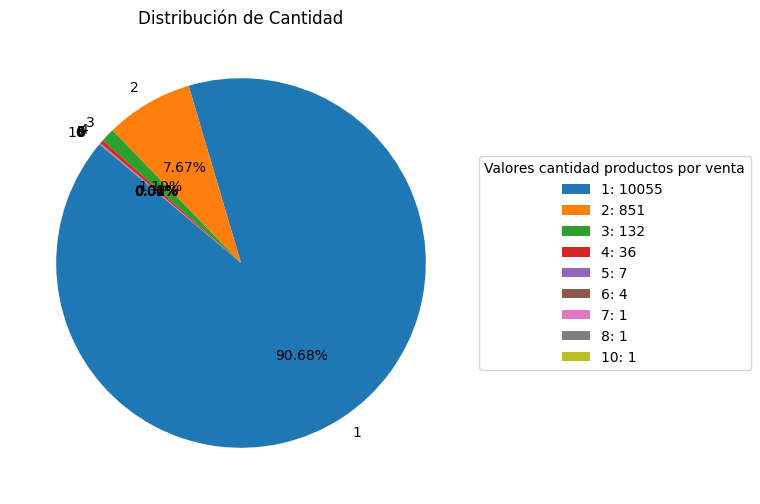

In [29]:
import matplotlib.pyplot as plt

# Filtrar valores no nulos y calcular frecuencia
cantidad_frecuencia = sales['CANTIDAD'].value_counts()

plt.figure(figsize=(6, 6))  # Ajustar tamaño del gráfico
wedges, texts, autotexts = plt.pie(
    cantidad_frecuencia, 
    labels=cantidad_frecuencia.index, 
    autopct='%2.2f%%', 
    startangle=140
)
leyenda = [f"{index}: {value} " for index, value in cantidad_frecuencia.items()]
plt.legend(
    wedges, 
    leyenda, 
    title="Valores cantidad productos por venta", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Cantidad')
plt.show()



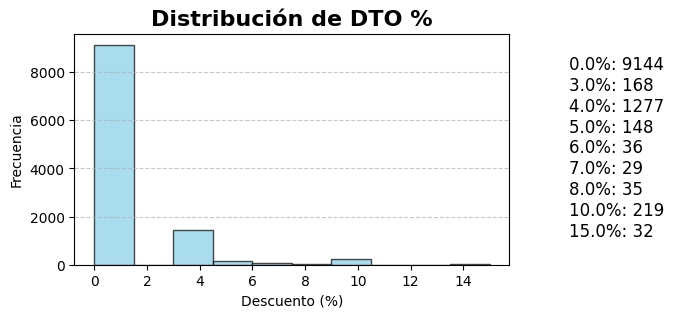

In [30]:
dto_frecuencia = sales['DTO %'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.hist(sales['DTO %'], bins=10, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribución de DTO %', fontsize=16, fontweight='bold')
plt.xlabel('Descuento (%)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

frecuencias_texto = "\n".join([f"{index}%: {value}" for index, value in dto_frecuencia.items()])
plt.gcf().text(0.95, 0.5, frecuencias_texto, fontsize=12, verticalalignment='center')
plt.subplots_adjust(right=0.85)

plt.show()

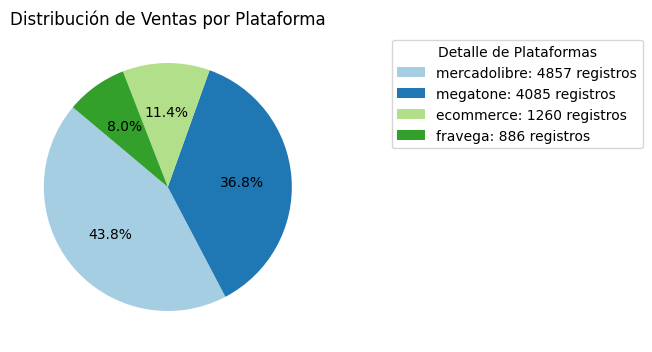

In [31]:
frecuencia_plataforma = sales['PLATAFORMA'].value_counts()

plt.figure(figsize=(4, 8))
plt.pie(
    frecuencia_plataforma,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Distribución de Ventas por Plataforma', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} registros" for index, value in frecuencia_plataforma.items()],
    title="Detalle de Plataformas",    
    loc="center left",
    bbox_to_anchor=(1.2, 0.8)  
)

plt.show()

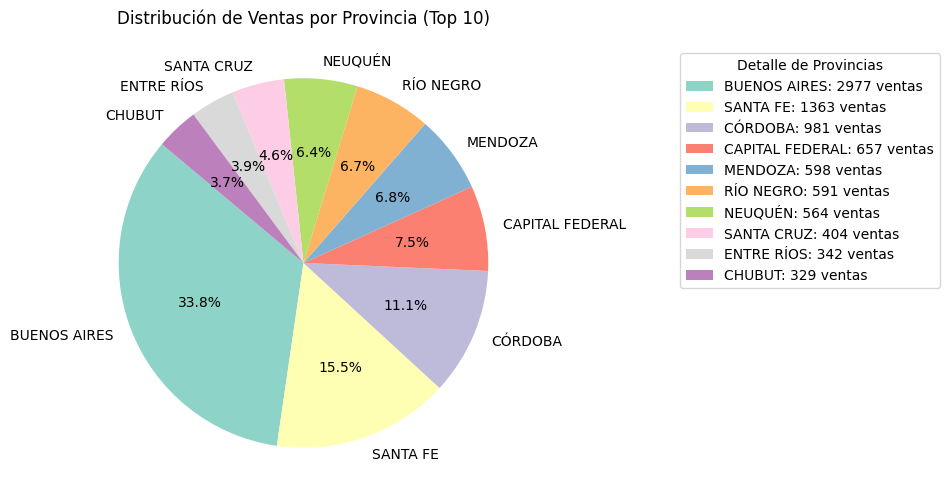

In [32]:
frecuencia_provincia = sales['PROVINCIA'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Provincia (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de Provincias",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()


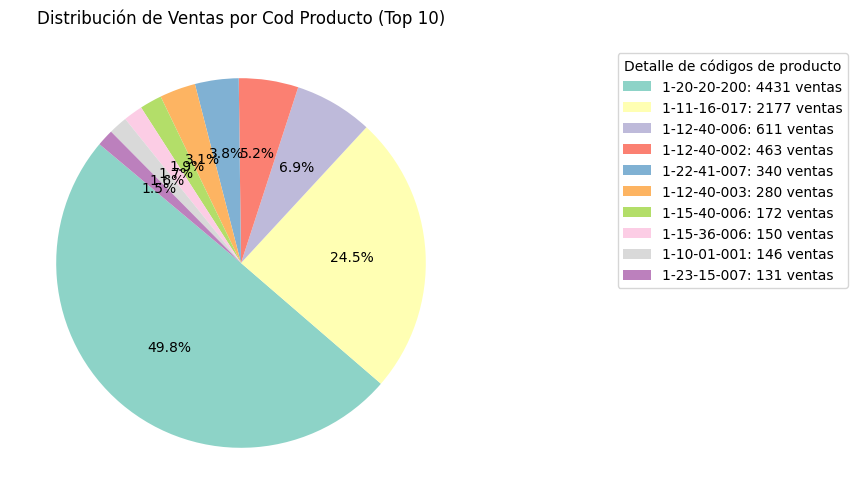

In [33]:
frecuencia_provincia = sales['COD. PRODUCTO'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Cod Producto (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de códigos de producto",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()

## Transformaciones Fecha Compra

In [34]:
# Convertir 'FECHA COMPRA' a datetime especificando el formato exacto
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], format='%d/%m/%Y')

In [35]:
# Crear columnas temporales
sales['AÑO'] = sales['FECHA COMPRA'].dt.year
sales['MES'] = sales['FECHA COMPRA'].dt.month

sales.sample(10)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD,AÑO,MES
3725,2022-10-31,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,RÍO NEGRO,Villa Regina,mercadolibre,1,2022,10
9225,2022-09-19,1-10-05-002,ALMOHADAS L.VISCOÉLASTICA 80CM,0.0,BUENOS AIRES,ZARATE,megatone,2,2022,9
814,2023-10-25,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,SANTA CRUZ,Los Antiguos,fravega,1,2023,10
7880,2022-02-01,1-10-01-002,ALMOHADAS L.COPO 80CM,0.0,CAPITAL FEDERAL,CAPITAL FEDERAL,megatone,1,2022,2
4522,2023-01-27,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,Coronel Suárez,mercadolibre,1,2023,1
9691,2022-11-24,1-15-40-006,CONJUNTO L. ROMA TRADICIONAL 140CMX190CM,4.0,SANTA FE,Santa Fe,megatone,1,2022,11
2977,2022-07-05,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,LA RIOJA,Milagro,mercadolibre,1,2022,7
6830,2023-11-16,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,NEUQUÉN,Villa La Angostura,mercadolibre,1,2023,11
9543,2022-11-02,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,4.0,BUENOS AIRES,BELLA VISTA,megatone,1,2022,11
8263,2022-05-14,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,SANTA FE,ROSARIO,megatone,1,2022,5


* Distribucion de ventas por mes

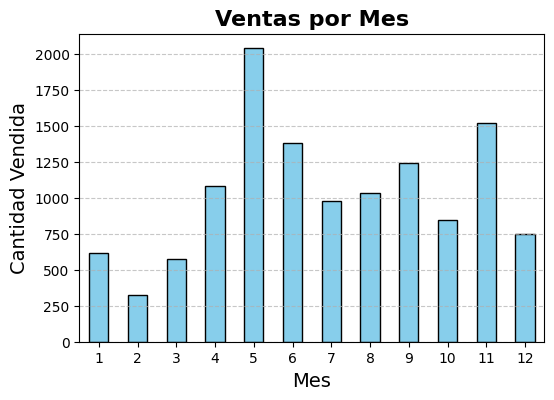

In [36]:
ventas_por_mes = sales.groupby('MES')['CANTIDAD'].sum()

plt.figure(figsize=(6, 4))
ventas_por_mes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ventas por Mes', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## Adapto el dataset para analizar tanto patrones semanales como mensuales. El objetivo es trabajar con la predicción por período de tiempo y agrupar las ventas por un intervalo de tiempo y producto

In [37]:
# Agregar columna de EVENTO
sales['EVENTO'] = sales['MES'].apply(
    lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Estandar')
)

# Agrupar por 'COD. PRODUCTO', 'AÑO', y 'MES', sumando las cantidades vendidas ('CANTIDAD_TOTAL')
sales_grouped = sales.groupby(['AÑO', 'MES', 'COD. PRODUCTO', 'PRODUCTO', 'DTO %']).agg(
    CANTIDAD_TOTAL=('CANTIDAD', 'sum')  # Sumamos las cantidades vendidas por mes y producto
).reset_index()
# Verificar que los productos sin ventas estén con CANTIDAD_TOTAL = 0
sales_grouped.sample(10)

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL
657,2022,9,1-14-07-006,CONJUNTO L. HARTMANN TRADICIONAL 140CMX190CM,5.0,2
221,2021,11,1-10-01-002,ALMOHADAS L.COPO 80CM,0.0,9
209,2021,10,1-14-17-018,CONJUNTO L. DONATELLO TRADICIONAL 180CMX200CM,0.0,1
560,2022,7,1-11-07-006,COLCHÓN L. HARTMANN TRADICIONAL 140CMX190CM,0.0,1
1039,2023,8,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,64
96,2021,7,1-12-40-004,COLCHÓN L. ROMA TRADICIONAL 100CMX190CM,0.0,2
101,2021,7,1-14-17-018,CONJUNTO L. DONATELLO TRADICIONAL 180CMX200CM,0.0,1
678,2022,10,1-11-02-002,COLCHÓN L. SUPER CONFORT TRADICIONAL 80CMX190CM,0.0,1
684,2022,10,1-11-08-002,COLCHÓN L. PEKIN TRADICIONAL 80CMX190CM,0.0,3
54,2021,6,1-11-06-004,COLCHÓN L. RELAX 22 TRADICIONAL 100CMX190CM,0.0,1


In [38]:
cod_productos_unicos = sales_grouped['COD. PRODUCTO'].unique()
print(f"TODOS LOS COD. PRODUCTO: {cod_productos_unicos}")

# Contar cuántos COD. PRODUCTO únicos existen
num_cod_productos_unicos = len(sales_grouped['COD. PRODUCTO'].unique())

# Mostrar el resultado
print(f"Cantidad de COD. PRODUCTO únicos: {num_cod_productos_unicos}")


TODOS LOS COD. PRODUCTO: ['1-12-40-006' '1-12-40-003' '1-10-03-001' '1-10-03-002' '1-10-05-002'
 '1-11-06-002' '1-12-40-002' '1-10-01-001' '1-10-01-002' '1-10-02-001'
 '1-10-04-002' '1-10-05-001' '1-11-06-003' '1-11-06-004' '1-11-06-006'
 '1-11-11-006' '1-11-11-017' '1-11-12-006' '1-12-27-006' '1-12-27-018'
 '1-12-30-006' '1-12-36-002' '1-12-40-004' '1-14-11-006' '1-14-11-017'
 '1-14-15-002' '1-15-40-006' '1-20-20-200' '1-22-41-002' '1-10-02-002'
 '1-11-02-002' '1-11-16-017' '1-14-11-019' '1-15-36-006' '1-15-37-019'
 '1-15-38-019' '1-11-02-06' '1-11-06-005' '1-11-16-002' '1-11-17-017'
 '1-12-27-002' '1-12-38-017' '1-14-17-018' '1-14-17-019' '1-12-37-002'
 '1-14-17-017' '1-15-38-006' '1-22-41-003' '1-11-08-002' '1-11-11-018'
 '1-11-12-017' '1-12-37-019' '1-14-11-018' '1-15-27-018' '1-15-38-018'
 '1-15-40-004' '1-23-16-001' '1-11-08-003' '1-11-12-018' '1-12-27-017'
 '1-14-16-002' '1-23-37-004' '1-11-07-002' '1-11-07-003' '1-11-07-006'
 '1-11-10-006' '1-11-17-018' '1-13-32-006' '1-14-07-0

In [39]:
sales_grouped.sample(10)

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL
936,2023,5,1-14-11-006,CONJUNTO L. ATENAS TRADICIONAL 140CMX190CM,0.0,7
268,2021,11,1-15-37-019,CONJUNTO L. VASARI TRADICIONAL 200CMX200CM,0.0,1
688,2022,10,1-11-10-019,COLCHÓN L. PLATINUM TRADICIONAL 200CMX200CM,4.0,1
1027,2023,8,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,1
57,2021,6,1-12-36-002,COLCHÓN L. SANZIO TRADICIONAL 80CMX190CM,0.0,12
36,2021,5,1-14-15-002,CONJUNTO L. DALI TRADICIONAL 80CMX190CM,0.0,1
253,2021,11,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,17
1128,2023,12,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,2
93,2021,7,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,5.0,8
6,2021,4,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,0.0,1


In [40]:
sales.shape

(11088, 11)

In [41]:
# Crear un DataFrame con todas las combinaciones posibles de AÑO, MES y COD. PRODUCTO
# Primero obtenemos todos los valores únicos de 'AÑO', 'MES', y 'COD. PRODUCTO'
#años = sales_grouped['AÑO'].unique()
#meses = sales_grouped['MES'].unique()
#cod_productos_unicos = sales_grouped['COD. PRODUCTO'].unique()

# Crear todas las combinaciones posibles (todos los productos por cada año y mes)
#combinaciones = pd.MultiIndex.from_product([años, meses, cod_productos_unicos], names=['AÑO', 'MES', 'COD. PRODUCTO'])

# Crear un DataFrame con estas combinaciones
#combinaciones_df = pd.DataFrame(index=combinaciones).reset_index()

# Agrupar el dataset original para obtener las ventas totales
#sales_grouped = sales_grouped.groupby(['AÑO', 'MES', 'COD. PRODUCTO'], as_index=False).agg(
#    CANTIDAD_TOTAL=('CANTIDAD', 'sum'),
#    PRODUCTO=('PRODUCTO', 'first'),
#    EVENTO=('EVENTO', 'first')
#)

# Merge con las combinaciones para obtener el valor 0 para los productos no vendidos
#sales_final = pd.merge(combinaciones_df, sales_grouped, on=['AÑO', 'MES', 'COD. PRODUCTO'], how='left')

#sales_final['CANTIDAD_TOTAL'] = sales_final['CANTIDAD_TOTAL'].fillna(0)
# Merge con las combinaciones para obtener el valor 0 para los productos no vendidos
#sales_final = pd.merge(combinaciones_df, sales_grouped, on=['AÑO', 'MES', 'COD. PRODUCTO'], how='left')

In [42]:
prod_map = (
    sales[['COD. PRODUCTO', 'PRODUCTO']]
    .dropna(subset=['COD. PRODUCTO', 'PRODUCTO'])
    .astype({'COD. PRODUCTO': str})
    .drop_duplicates(subset=['COD. PRODUCTO'])
    .set_index('COD. PRODUCTO')['PRODUCTO']
)

años = sales_grouped['AÑO'].unique()
meses = sales_grouped['MES'].unique()
cods = sales_grouped['COD. PRODUCTO'].astype(str).unique()

combinaciones = pd.MultiIndex.from_product(
    [años, meses, cods],
    names=['AÑO', 'MES', 'COD. PRODUCTO']
)
combinaciones_df = pd.DataFrame(index=combinaciones).reset_index()

sales_grouped = sales_grouped.copy()
sales_grouped['COD. PRODUCTO'] = sales_grouped['COD. PRODUCTO'].astype(str)

sales_final = pd.merge(
    combinaciones_df,
    sales_grouped,
    on=['AÑO', 'MES', 'COD. PRODUCTO'],
    how='left'
)

sales_final['PRODUCTO'] = sales_final['PRODUCTO'].combine_first(
    sales_final['COD. PRODUCTO'].map(prod_map)
)

if 'CANTIDAD_TOTAL' in sales_final.columns:
    sales_final['CANTIDAD_TOTAL'] = sales_final['CANTIDAD_TOTAL'].fillna(0)

if 'DTO %' in sales_final.columns:
    sales_final['DTO %'] = sales_final['DTO %'].fillna(0)
sales_final.sample(15)

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL
2629,2022,4,1-22-41-002,CONJUNTO MARINERA L. MONET BLACK,0.0,0.0
4061,2023,6,1-10-01-001,ALMOHADAS L.COPO 70CM,0.0,0.0
3477,2022,2,1-14-11-006,CONJUNTO L. ATENAS TRADICIONAL 140CMX190CM,0.0,0.0
915,2002,1,1-15-36-006,CONJUNTO L. SANZIO TRADICIONAL 140CMX190CM,0.0,0.0
5086,2024,4,1-12-37-002,COLCHÓN L. VASARI TRADICIONAL 80CMX190CM,0.0,0.0
5863,2024,2,1-11-06-005,COLCHÓN L. RELAX 22 TRADICIONAL 130CMX190CM,0.0,0.0
1638,2021,6,1-11-12-017,COLCHÓN L. MONACO TRADICIONAL 160CMX200CM,0.0,0.0
5912,2024,2,1-14-60-004,CONJ GILOT TRAD 100X190,0.0,0.0
3444,2022,1,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,0.0
636,2002,8,1-11-08-002,COLCHÓN L. PEKIN TRADICIONAL 80CMX190CM,0.0,0.0


In [43]:
sales_final.head()

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL
0,2002,10,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,1.0
1,2002,10,1-12-40-003,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,0.0,0.0
2,2002,10,1-10-03-001,ALMOHADAS L.SUPER SOFT 70CM,0.0,0.0
3,2002,10,1-10-03-002,ALMOHADAS L.SUPER SOFT 80CM,0.0,0.0
4,2002,10,1-10-05-002,ALMOHADAS L.VISCOÉLASTICA 80CM,0.0,0.0


In [44]:
sales_final.shape

(6022, 6)

In [45]:
sales_final['EVENTO'] = sales_final['MES'].apply(
    lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Estandar')
)

sales_final['CANTIDAD_TOTAL'] = sales_final['CANTIDAD_TOTAL'].apply(
    lambda x: 0 if pd.isna(x) else x
)

# Eliminar filas donde 'AÑO' sea 2024 y 'MES' sea mayor o igual a 3
sales_final = sales_final[~((sales_final['AÑO'] == 2024) & (sales_final['MES'] >= 3))]

#sales_rename = sales_final[['COD. PRODUCTO', 'PRODUCTO']].rename(columns={'PRODUCTO': 'DESC_PRODUCTO'})
# Realizar el merge sin crear columnas duplicadas
#sales_final = pd.merge(sales_final, sales_rename, on='COD. PRODUCTO', how='left')

In [46]:
sales_final.sample(10)

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL,EVENTO
5832,2024,2,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,0.0,0.0,Estandar
5802,2024,1,1-15-40-003,CONJUNTO L. ROMA TRADICIONAL 90CMX190CM,0.0,1.0,Estandar
3480,2022,2,1-15-40-006,CONJUNTO L. ROMA TRADICIONAL 140CMX190CM,0.0,4.0,Estandar
3665,2023,10,1-10-05-001,ALMOHADAS L.VISCOÉLASTICA 70CM,0.0,0.0,Estandar
5885,2024,2,1-12-27-017,COLCHÓN L. GRANATE TRADICIONAL 160CMX200CM,0.0,0.0,Estandar
781,2002,9,1-23-16-003,PROMO 2 COLCHONES L.REMBRANDT 100CMX190XM,0.0,0.0,Estandar
1078,2002,3,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,0.0,Estandar
1082,2002,3,1-10-05-002,ALMOHADAS L.VISCOÉLASTICA 80CM,0.0,0.0,Estandar
2560,2022,12,1-11-08-003,COLCHÓN L. PEKIN TRADICIONAL 90CMX190CM,0.0,0.0,Estandar
3119,2022,8,1-14-60-003,CONJ GILOT TRAD 90X190,0.0,0.0,Estandar


In [47]:
sales_final.head()

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL,EVENTO
0,2002,10,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,1.0,Estandar
1,2002,10,1-12-40-003,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,0.0,0.0,Estandar
2,2002,10,1-10-03-001,ALMOHADAS L.SUPER SOFT 70CM,0.0,0.0,Estandar
3,2002,10,1-10-03-002,ALMOHADAS L.SUPER SOFT 80CM,0.0,0.0,Estandar
4,2002,10,1-10-05-002,ALMOHADAS L.VISCOÉLASTICA 80CM,0.0,0.0,Estandar


In [48]:
sales_final.shape

(5042, 7)

In [49]:
#top_productos = sales_final.groupby("COD. PRODUCTO")["CANTIDAD_TOTAL"].sum().nlargest(10).index
#ventas_top_productos = sales_final[sales_final["COD. PRODUCTO"].isin(top_productos)]

# Obtengo el nombre del producto correspondiente a cada código
#mapa_productos = ventas_top_productos[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates().set_index('COD. PRODUCTO')['PRODUCTO'].to_dict()
#ventas_top_productos.loc[:, 'PRODUCTO'] = ventas_top_productos['COD. PRODUCTO'].map(mapa_productos)

# Agrupo sumando ventas totales por mes y ordeno los productos por cantidad total de ventas
#ventas_top_productos = ventas_top_productos.groupby(['MES', 'PRODUCTO'])['CANTIDAD_TOTAL'].sum().reset_index()
#total_ventas_por_producto = ventas_top_productos.groupby("PRODUCTO")["CANTIDAD_TOTAL"].sum().sort_values(ascending=False)
#productos_ordenados = total_ventas_por_producto.index

#plt.figure(figsize=(10,6))
#sns.lineplot(data=ventas_top_productos, x="MES", y="CANTIDAD_TOTAL", hue="PRODUCTO", marker="o", palette="tab10", hue_order=productos_ordenados)

#handles, labels = plt.gca().get_legend_handles_labels()
#nuevas_labels = [f"{prod}" for prod in labels]
#plt.legend(handles, nuevas_labels, title="Producto (Total Vendido)", fontsize=10, title_fontsize=12)

# etiquetas
#plt.title("Evolución de Ventas Mensuales - Top 10 Productos (Suma de Todos los Años)", fontsize=14)
#plt.xlabel("Mes", fontsize=12)
#plt.ylabel("Cantidad Total Vendida", fontsize=12)
#plt.xticks(range(1,13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
#plt.grid()

#plt.show()

# Hipótesis sobre los datos

## Hipotesis 1: 

#### Comparación de ventas promedio en meses normales vs. eventos

In [50]:
ventas_por_evento = sales_final.assign(
    TIPO_MES = sales_final['MES'].apply(
        lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Mes Normal')
    )
)

ventas_por_evento = ventas_por_evento.groupby("TIPO_MES")["CANTIDAD_TOTAL"].mean().reset_index()

from IPython.display import display
display(ventas_por_evento)


,TIPO_MES,CANTIDAD_TOTAL
0,CyberMonday,3.712195
1,Hot Sale,4.884892
2,Mes Normal,2.093001


##### Los meses con Hot Sale y CyberMonday tienen ventas superiores a los meses normales.

* En meses normales, se venden en promedio 31 unidades de un producto por mes.
* Durante CyberMonday, este número aumenta a 50 unidades.
* En Hot Sale, la cantidad promedio sube aún más a 73 unidade.
  
##### Hot Sale parece generar un mayor impacto en las ventas que CyberMonday.

* El aumento en Hot Sale es mayor que en CyberMonday.
* Esto podría deberse a que mayo (Hot Sale) tiene más días promocionales, o a que hay una mayor demanda en ese momento del año

##### Calculamos el porcentaje de aumento en ventas en estos eventos:

* Hot Sale vs. Mes Normal: Hubo un aumento del 134% en las ventas durante Hot Sale en comparación con los meses normales.

* CyberMonday vs. Mes Normal: Hubo un aumento del 64% en las ventas durante CyberMonday en comparación con los meses normales.

#### Conclusión
✔ Confirmamos la hipótesis: Hot Sale y CyberMonday aumentan significativamente las ventas.

✔ El impacto es mayor en Hot Sale (≈ 134% más ventas), que en CyberMonday (≈ 64% más ventas).

# Modelado

### Elección de la métrica de performance a utilizar para evaluar los modelos y fundamentación.

Para evaluar el desempeño de los modelos de regresión desarrollados para predecir la cantidad de productos vendidos, es fundamental elegir una métrica que refleje de manera fiel el error de predicción en el contexto del negocio.

En este caso, la variable objetivo (cantidad de productos vendidos) presenta una distribución altamente desbalanceada: la mayoría de los valores son bajos y existen pocos valores atípicos (ventas inusualmente altas). Por este motivo, se selecciona el **Error Absoluto Medio (MAE, Mean Absolute Error)** como métrica principal de evaluación.

El MAE representa el error promedio absoluto entre las predicciones y los valores reales, expresado en las mismas unidades que la variable objetivo. Esta métrica es especialmente adecuada en contextos donde:
 - La mayoría de los valores son bajos y los outliers no deben dominar la evaluación.
 - Se busca una interpretación sencilla y directa del error promedio, fácilmente comunicable a áreas de negocio.
 - Se desea evitar que unos pocos errores grandes (outliers) distorsionen la percepción del desempeño general del modelo.

Complementariamente, se reporta la Raíz del Error Cuadrático Medio (RMSE), que penaliza más fuertemente los errores grandes y puede ser útil para identificar el impacto de los outliers. Sin embargo, la métrica principal para comparar y seleccionar modelos será el MAE, ya que refleja mejor el comportamiento típico del modelo en la mayoría de los casos reales de predicción de ventas

### Próximo paso será entrenar y evaluar diversos algoritmos, realizando una exploración de hiperparámetros mediante una búsqueda en cuadrícula (grid search). Posteriormente, se evaluará el comportamiento de cada modelo utilizando los hiperparámetros que den los mejores resultados, proporcionando conclusiones sobre la comparación entre ellos.

In [51]:
#Elimino los dos registros outliers con data (seguramente mal cargada) del 2002
#sales_final = sales_final[sales_final['AÑO'] != 2002]
#sales_final.head()

In [52]:
sales_final.shape

(5042, 7)

In [53]:
sales_final['AÑO'] = pd.to_numeric(sales_final['AÑO'], errors='coerce')
sales_final['MES'] = pd.to_numeric(sales_final['MES'], errors='coerce')

sales_final = sales_final.sort_values(by=['AÑO', 'MES'], ascending=[True, True])
sales_final.head()

,AÑO,MES,COD. PRODUCTO,PRODUCTO,DTO %,CANTIDAD_TOTAL,EVENTO
882,2002,1,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,0.0,Estandar
883,2002,1,1-12-40-003,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,0.0,0.0,Estandar
884,2002,1,1-10-03-001,ALMOHADAS L.SUPER SOFT 70CM,0.0,0.0,Estandar
885,2002,1,1-10-03-002,ALMOHADAS L.SUPER SOFT 80CM,0.0,0.0,Estandar
886,2002,1,1-10-05-002,ALMOHADAS L.VISCOÉLASTICA 80CM,0.0,0.0,Estandar


In [54]:
sales_final.shape

(5042, 7)

In [55]:
sales_final = sales_final.drop_duplicates(subset=['AÑO', 'MES', 'COD. PRODUCTO'])

In [56]:
sales_final.shape

(4900, 7)

In [57]:
# Dividir el dataset en train, validation y test (60%, 20%, 20%)
train_size = int(0.6 * len(sales_final))  # El 60% del dataset
validation_size = int(0.2 * len(sales_final))  # El 20% del dataset

# Dividir el dataset
train = sales_final[:train_size]
validation = sales_final[train_size:train_size + validation_size]
test = sales_final[train_size + validation_size:]

# Verificar las formas de los datasets
print(train.shape, validation.shape, test.shape)

(2940, 7) (980, 7) (980, 7)


In [58]:
X_train = train.drop(columns=['CANTIDAD_TOTAL'])  
y_train = train['CANTIDAD_TOTAL']  

X_test = test.drop(columns=['CANTIDAD_TOTAL'])  
y_test = test['CANTIDAD_TOTAL']  

X_validation = validation.drop(columns=['CANTIDAD_TOTAL'])  
y_validation = validation['CANTIDAD_TOTAL']  

In [59]:
mapper = DataFrameMapper([
    (['AÑO', 'MES'], [StandardScaler()]),
    (['COD. PRODUCTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
    (['EVENTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
], input_df=True)

mapper.fit(X_train)
X_train_transformed = mapper.transform(X_train)
X_val_transformed   = mapper.transform(X_validation)
X_test_transformed  = mapper.transform(X_test)

C:\Users\bosch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


### Entrenamiento modelo Regresion Lineal

In [60]:

# Defino el modelo de regresión lineal
lr_clasif = LinearRegression()
lr_clasif.fit(X_train_transformed, y_train)
y_pred_validation = lr_clasif.predict(X_val_transformed)

rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)

print(f"RMSE en validation: {rmse_validation:.4f}")
print(f"MAE en validation: {mae_validation:.4f}")
print(f"r2 en validation: {r2_validation:.4f}")


RMSE en validation: 25.9321
MAE en validation: 4.3577
r2 en validation: 0.1498


### Entrenamiento modelo RIDGE

In [61]:
ridge_model = Ridge()
parameters = {
    'alpha': [ 0.1, 1, 5,10,50]    
}
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=parameters, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train_transformed, y_train)
best_ridge_model = grid_search_ridge.best_estimator_
print("Mejores parámetros Ridge:", grid_search_ridge.best_params_)

y_pred_ridge = best_ridge_model.predict(X_val_transformed)
rmse_ridge = np.sqrt(mean_squared_error(y_validation, y_pred_ridge))
mae_ridge = mean_absolute_error(y_validation, y_pred_ridge)
r2_ridge = r2_score(y_validation, y_pred_ridge)

print(f"RMSE en validation (Ridge): {rmse_ridge:.4f}")
print(f"MAE en validation (Ridge): {mae_ridge:.4f}")
print(f"R2 en validation (Ridge): {r2_ridge:.4f}")



Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores parámetros Ridge: {'alpha': 50}
RMSE en validation (Ridge): 27.2573
MAE en validation (Ridge): 4.9462
R2 en validation (Ridge): 0.0607


### Entrenamiento modelo LASSO

In [62]:
lasso_model = Lasso()
parameters = {'alpha': [0.01, 0.1, 1, 5, 10]}
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=parameters, cv=2, scoring='neg_mean_squared_error', verbose=1)
grid_search_lasso.fit(X_train_transformed, y_train)
best_lasso_model = grid_search_lasso.best_estimator_
print("Mejores parámetros Lasso:", grid_search_lasso.best_params_)

y_pred_lasso = best_lasso_model.predict(X_val_transformed)
rmse_lasso = np.sqrt(mean_squared_error(y_validation, y_pred_lasso))
mae_lasso = mean_absolute_error(y_validation, y_pred_lasso)
r2_lasso = r2_score(y_validation, y_pred_lasso)


print(f"RMSE en validation (Lasso): {rmse_lasso:.4f}")
print(f"MAE en validation (Lasso): {mae_lasso:.4f}")
print(f"R2 en validation (Lasso): {r2_lasso:.4f}")


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Mejores parámetros Lasso: {'alpha': 1}
RMSE en validation (Lasso): 28.2695
MAE en validation (Lasso): 4.7499
R2 en validation (Lasso): -0.0104


### Entrenamiento modelo ÁRBOL DE DECISIÓN 

In [63]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 10]
}
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_dt.fit(X_train_transformed, y_train)
best_dt_model = grid_search_dt.best_estimator_
print("Mejores parámetros para Árbol de Decisión:", grid_search_dt.best_params_)

y_pred_dt = best_dt_model.predict(X_val_transformed)
rmse_validation_dt = np.sqrt(mean_squared_error(y_validation, y_pred_dt))
mae_dt = mean_absolute_error(y_validation, y_pred_dt)
r2_dt = r2_score(y_validation, y_pred_dt)

print(f"RMSE en validation (Árbol de Decisión): {rmse_validation_dt:.4f}")
print(f"MAE en validation (Árbol de Decisión): {mae_dt:.4f}")
print(f"R2 en validation (Árbol de Decisión): {r2_dt:.4f}")

X_tv = np.vstack([X_train_transformed, X_val_transformed])
y_tv = np.concatenate([np.asarray(y_train).ravel(), np.asarray(y_validation).ravel()])

dt_refit = clone(best_dt_model)   # misma configuración que el mejor encontrado
dt_refit.fit(X_tv, y_tv)

y_pred_test = dt_refit.predict(X_test_transformed)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test  = mean_absolute_error(y_test, y_pred_test)
r2_test   = r2_score(y_test, y_pred_test)
print(f"Test       -> RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | R2: {r2_test:.4f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejores parámetros para Árbol de Decisión: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
RMSE en validation (Árbol de Decisión): 24.9298
MAE en validation (Árbol de Decisión): 4.0339
R2 en validation (Árbol de Decisión): 0.2142
Test       -> RMSE: 31.0803 | MAE: 4.6156 | R2: 0.0970


### Entrenamiento modelo RANDOM FOREST

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [25, 50, 75, 100], 
    'max_depth': [None, 2, 5, 8],  
    'min_samples_split': [5, 10], 
    'min_samples_leaf': [1, 2],  
    'bootstrap': [True] 
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train_transformed, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

y_pred_rf = best_rf_model.predict(X_val_transformed)
rmse_validation_rf = np.sqrt(mean_squared_error(y_validation, y_pred_rf))
mae_rf = mean_absolute_error(y_validation, y_pred_rf)
r2_rf = r2_score(y_validation, y_pred_rf)

print(f"RMSE en Validación (Random Forest): {rmse_validation_rf:.4f}")
print(f"MAE en Validación (Random Forest): {mae_rf:.4f}")
print(f"R2 en Validación (Random Forest): {r2_rf:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parámetros para Random Forest: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RMSE en Validación (Random Forest): 26.5348
MAE en Validación (Random Forest): 4.3358
R2 en Validación (Random Forest): 0.1098


In [65]:
gbr_model = GradientBoostingRegressor(random_state=42)

gbr_params = {
    'n_estimators': [100, 300, 600],
    'learning_rate': [0.03, 0.1],
    'max_depth': [2, 3],
    'min_samples_leaf': [1, 2],
    'subsample': [1.0, 0.8]
}

grid_search_gbr = GridSearchCV(
    estimator=gbr_model,
    param_grid=gbr_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search_gbr.fit(X_train_transformed, y_train)

best_gbr_model = grid_search_gbr.best_estimator_
print("Mejores parámetros para Gradient Boosting:", grid_search_gbr.best_params_)

y_pred_gbr = best_gbr_model.predict(X_val_transformed)

rmse_validation_gbr = np.sqrt(mean_squared_error(y_validation, y_pred_gbr))
mae_gbr = mean_absolute_error(y_validation, y_pred_gbr)
r2_gbr = r2_score(y_validation, y_pred_gbr)

print(f"RMSE en validation (Gradient Boosting): {rmse_validation_gbr:.4f}")
print(f"MAE en validation (Gradient Boosting): {mae_gbr:.4f}")
print(f"R2 en validation (Gradient Boosting): {r2_gbr:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.03, 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'subsample': 1.0}
RMSE en validation (Gradient Boosting): 25.8716
MAE en validation (Gradient Boosting): 4.4019
R2 en validation (Gradient Boosting): 0.1538


### Resultado evaluación modelos con el DataSet original

**Árbol de Decisión** — mejor desempeño
- RMSE 24.93 | MAE 4.03. Es el que menor error logra. Indica que hay patrones no lineales que los modelos lineales no capturan.

**Regresión Lineal** — 
- RMSE 25.93 | MAE 4.36. Capta tendencias generales con un error medio cercano a 4–5 unidades por producto-mes.

**Random Forest** — resultado intermedio
- RMSE 26.53 | MAE 4.34. Rendimiento similar a la lineal; no supera al Árbol en esta validación.

**Gradient Boosting** — segundo mejor candidato
- RMSE 25.87 | MAE 4.40. Buen equilibrio sesgo–varianza, cercano al rendimiento del Árbol.

**Ridge / Lasso** — no aportan mejora
- Ridge: RMSE 27.26 | MAE 4.95.
- Lasso: RMSE 28.27 | MAE 4.75.


### Conclusión
A partir de los resultados de validación, el **Árbol de Decisión** es el modelo con **mejor desempeño**: obtuvo el menor MAE (4.03) y el menor RMSE (24.93), lo que indica que capta patrones no lineales que los modelos lineales no logran representar. En segundo lugar se ubicó **Gradient Boosting** (MAE 4.40; RMSE 25.87), con un rendimiento cercano. La Regresión Lineal ofrece un baseline competitivo (MAE 4.36; RMSE 25.93), mientras que Ridge (MAE 4.95) y Lasso (MAE 4.75) no mejoran al baseline en este conjunto.

En términos prácticos, los modelos presentan un error típico cercano a 4–5 unidades por producto-mes, por lo que el desempeño es moderado y consistente con la complejidad/variabilidad del dato disponible. Como siguiente paso, se adoptará el **Árbol de Decisión como modelo principal**, considerando Gradient Boosting como alternativa, incorporando mejora de variables.

### Transformación del Dataset en busca de mejoras en los resultados

In [66]:
sales_transformed = sales_final.copy()
sales_transformed['CANTIDAD_TOTAL'] = np.log1p(sales_transformed['CANTIDAD_TOTAL'])

train_transf, not_train_transf = train_test_split(sales_transformed, test_size=0.4, random_state=42)
validation_transf, test_transf = train_test_split(not_train_transf, test_size=0.5, random_state=42)

X_train_transf = train_transf.drop(columns=['CANTIDAD_TOTAL']) 
y_train_transf = train_transf['CANTIDAD_TOTAL'] 

X_validation_transf = validation_transf.drop(columns=['CANTIDAD_TOTAL']) 
y_validation_transf = validation_transf['CANTIDAD_TOTAL']  

X_test_transf = test_transf.drop(columns=['CANTIDAD_TOTAL']) 
y_test_transf = test_transf['CANTIDAD_TOTAL']  

mapper_transf = DataFrameMapper([    
    (['AÑO', 'MES'], [StandardScaler()]),    
    (['COD. PRODUCTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
    (['EVENTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
], input_df=True)

X_train_transformed = mapper_transf.fit_transform(X_train_transf)
X_validation_transformed = mapper_transf.transform(X_validation_transf)
X_test_transformed = mapper_transf.transform(X_test_transf)


C:\Users\bosch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_models_full(X_train, y_train, X_val, y_val, X_test, y_test, models, model_params=None):
    results = {}
    
    # Helper para R2 ajustado
    def r2_adjusted(r2, n, p):
        den = max(n - p - 1, 1)
        return 1 - (1 - r2) * (n - 1) / den

    n_tr, p = X_train.shape
    n_val = X_val.shape[0]
    n_te  = X_test.shape[0]

    for model_name, model in models.items():
        print(f"Evaluando el modelo: {model_name}")
        
        # GridSearchCV si corresponde
        if model_params and model_name in model_params:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=model_params[model_name],
                cv=3,
                scoring='neg_mean_squared_error',  # cambialo a 'r2' si querés optimizar por R2
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Predicciones
        y_pred_train = best_model.predict(X_train)
        y_pred_val   = best_model.predict(X_val)
        y_pred_test  = best_model.predict(X_test)
        
        # RMSE        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_val   = np.sqrt(mean_squared_error(y_val,   y_pred_val))
        rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))
        # MAE
        mae_train  = mean_absolute_error(y_train, y_pred_train)
        mae_val    = mean_absolute_error(y_val,   y_pred_val)
        mae_test   = mean_absolute_error(y_test,  y_pred_test)
        # R2
        r2_train = r2_score(y_train, y_pred_train)
        r2_val   = r2_score(y_val,   y_pred_val)
        r2_test  = r2_score(y_test,  y_pred_test)

        # R2 ajustado (opcional, pero útil para el informe)
        r2_adj_train = r2_adjusted(r2_train, n_tr, p)
        r2_adj_val   = r2_adjusted(r2_val,   n_val, p)
        r2_adj_test  = r2_adjusted(r2_test,  n_te,  p)

        results[model_name] = {
            'RMSE_train': rmse_train, 'MAE_train': mae_train, 'R2_train': r2_train, 'R2_adj_train': r2_adj_train,
            'RMSE_val':   rmse_val,   'MAE_val':   mae_val,   'R2_val':   r2_val,   'R2_adj_val':   r2_adj_val,
            'RMSE_test':  rmse_test,  'MAE_test':  mae_test,  'R2_test':  r2_test,  'R2_adj_test':  r2_adj_test
        }

    
    return results

#### Evaluación modelos con FE

In [68]:
# Modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Hiperparámetros para GridSearch (si aplicable)
model_params = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.1, 0.01, 0.001, 1]},
    'Decision Tree': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4]}
}

# Evaluar los modelos con los conjuntos de datos transformados
results = evaluate_models_full(
    X_train_transformed, y_train_transf,
    X_validation_transformed, y_validation_transf,
    X_test_transformed, y_test_transf,
    models, model_params
)

# Imprimir los resultados
print("Resultados de RMSE y MAE para todos los modelos (train, validation, test):")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Train      - RMSE: {metrics['RMSE_train']:.4f} | MAE: {metrics['MAE_train']:.4f}")
    print(f"  Validation - RMSE: {metrics['RMSE_val']:.4f} | MAE: {metrics['MAE_val']:.4f}")
    print(f"  Test       - RMSE: {metrics['RMSE_test']:.4f} | MAE: {metrics['MAE_test']:.4f}")

Evaluando el modelo: Linear Regression
Evaluando el modelo: Ridge
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros para Ridge: {'alpha': 1}
Evaluando el modelo: Lasso
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros para Lasso: {'alpha': 0.001}
Evaluando el modelo: Decision Tree
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros para Decision Tree: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}
Evaluando el modelo: Random Forest
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros para Random Forest: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Resultados de RMSE y MAE para todos los modelos (train, validation, test):

Linear Regression:
  Train      - RMSE: 0.6323 | MAE: 0.4255
  Validation - RMSE: 0.5502 | MAE: 0.3857
  Test       - RMSE: 0.6166 | MAE: 0.4119

Ridge:
  Train      - RMSE: 0.6325 | MAE: 0.4266
  

### Resultados luego de la transformación:
* **Random Forest (mejor generalización)**
  - Validación: MAE_log 0.2765 (≈ 32% de error típico: exp(0.2765)-1).
  - Test: MAE_log 0.3110 (≈ 36–37%).
  - Análisis: es el que mejor se traslada a test; sube algo el error pero se mantiene como el más confiable.
* **Árbol de Decisión (fuerte en validación, cae en test)**
  - Validación: MAE_log 0.2806 (≈ 32–33%).
  - Test: MAE_log 0.3271 (≈ 39%).
  - Análisis: muy bueno en val, pero pierde más en test ⇒ ligero sobreajuste.
* **Modelos lineales (Lineal / Ridge / Lasso)**
  - Validación: MAE_log ≈ 0.546–0.550 (47% de error típico).
  - Test: MAE_log ≈ 0.411–0.412 → ≈ 51%.
  - Análisis: peor desempeño; captan tendencias generales, pero no las no linealidades.

Interpretación práctica del MAE_log: si MAE_log ≈ 0.31, el error típico es ≈ 36%.
Ejemplo: 
- si el modelo predice 50 unidades, esperar un error típico de ±18 (36% de 50).
- si el modelo predice 25 unidades, esperar un error típico de ±9 (36% de 50).


#### Conclusión
Después de transformar la variable objetivo con logaritmo se llega al resultado que los ensambles no lineales funcionan mejor. El Modelo con mejor balance entre validacion y test es Random Forest. Árbol de Decisión queda como alternativa (muy bueno en val, algo más inestable en test). Los lineales quedan descartados como modelo final en esta versión del dataset.

#### Análisis:
 - Tras aplicar la transformación logarítmica a la variable objetivo y codificar AÑO, MES, COD. PRODUCTO y EVENTO, los errores quedaron más estables y comparables entre modelos: en la escala log, RMSE y MAE son cercanos, lo que indica que la transformación atenuó outliers y estabilizó la varianza (algo típico en series de ventas con picos).

- Los modelos lineales (Regresión Lineal, Ridge y Lasso) rinden muy parecido entre sí y quedan por detrás de los basados en árboles: en validación su MAE_log ronda 0.386–0.388 y en test ~0.412, lo que sugiere que capturan bien las tendencias generales pero no las no linealidades del problema.

- Los modelos de árbol muestran la ventaja de capturar interacciones y relaciones no lineales. El Árbol de Decisión logra un MAE_log de 0.281 en validación, pero pierde en test (0.327), señal de ligero sobreajuste o sensibilidad a cambios de distribución. En cambio, el Random Forest es el que mejor generaliza: MAE_log de 0.277 en validación y 0.311 en test, manteniendo el mejor balance entre ajuste y estabilidad.

- Interpretación práctica del error: un MAE_log ≈ 0.28–0.31 equivale a un error típico del ~32–37 % (aprox. exp(MAE_log) − 1). Es decir, si el modelo pronostica 50 unidades, el desvío esperable ronda ±16 a ±19 unidades; si pronostica 25, el desvío típico es ±8 a ±9. Este marco permite comunicar al negocio “cuán buena” es cada predicción.

- EVENTO como feature ayuda a diferenciar meses promocionales de meses normales, y los modelos de árbol/ensamble aprovechan mejor esa señal que los lineales.